In [15]:
import gzip
import pickle
import pandas as pd
import numpy as np
import snana
import json
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
%matplotlib inline

LSST_FILTERS = 'ugrizY'

routine for converting JSON from the open supernova catalaog to SNANA format

In [23]:
def mkPhotFile_Err(fname='PTF11bij.json',outfile='PTF11bij.snana.dat',
                   surveyname='NULL',pkmjd=None,filtlist=None):
    filtdict = {}
    with open(fname) as data_file:
        data = json.load(data_file)

    snid = fname.split('.')[0].split('/')[-1]
    nobs = len(data[snid]['photometry'])
    try:
        z = float(data[snid]['redshift'][0]['value'])
    except:
        z = 0
        print('warning : no redshift for file %s'%fname)
    peakdate = data[snid]['maxdate'][0]['value']

    if not pkmjd:
        from astropy.time import Time
        times = ['%sT00:00:00'%peakdate.replace('/','-')]
        t = Time(times,format='isot',scale='utc')
        pkmjd = t.mjd[0]

    if not filtlist and snid not in filtdict.keys():
        filters = ''
        for phot in data[snid]['photometry']:
            if 'band' in phot.keys():
                if phot['band'] not in filters and phot['band'].replace("'","") not in filters and \
                   phot['band'].replace("'","") in ['U','B','V','R','I','u','g','r','i','z']:
                    filters += phot['band'].replace("'","")
    elif snid in filtdict.keys():
        filters = filtdict[snid]
    else:
        filters = filtlist
        
    snanahdr = """SNID: %s
SURVEY: %s
FILTERS: %s
REDSHIFT_FINAL: %.4f +- 0.0010
PEAKMJD: %s

NOBS: %i
NVAR: 7
VARLIST:  MJD  MJDERR  FLT FIELD   FLUXCAL	 FLUXCALERR	   MAG	   MAGERR
"""%(snid,surveyname,filters,z,pkmjd,nobs)

    fout = open(outfile,'w')
    print(snanahdr,file=fout)

    for phot in data[snid]['photometry']:
        linefmt = 'OBS: %.1f  %.1f  %s  NULL	%.3f  %.3f	%.3f  %.3f'
        if 'band' in phot.keys() and 'time' in phot.keys() and phot['band'].replace("'","") in filters:
            if 'system' in phot.keys() and phot['band'] == phot['band'].upper() and len(phot['band']) == 1 and phot['system'] == 'AB':
                print('AHHHHH AB MAG FOR FILTER %s'%phot['band'])
            if 'e_time' in phot.keys() and 'e_magnitude' in phot.keys():
                print(linefmt%(float(phot['time']),float(phot['e_time']),phot['band'].replace("'",""),10**(-0.4*(float(phot['magnitude'])-27.5)),
                                        np.abs(float(phot['e_magnitude'])*0.4*np.log(10)*10**(-0.4*(float(phot['magnitude'])-27.5))),float(phot['magnitude']),float(phot['e_magnitude'])),file=fout)
            elif 'e_magnitude' in phot.keys():
                print(linefmt%(float(phot['time']),0.0,phot['band'].replace("'",""),10**(-0.4*(float(phot['magnitude'])-27.5)),
                                     np.abs(float(phot['e_magnitude'])*0.4*np.log(10)*10**(-0.4*(float(phot['magnitude'])-27.5))),
                                      float(phot['magnitude']),float(phot['e_magnitude'])),file=fout)

            elif 'upperlimit' in phot.keys() and phot['upperlimit'] == True:
                flux_upperlim = 10**(-0.4*(float(phot['magnitude'])-27.5))
                fluxerr = flux_upperlim/3.
                flux = 0

                print(linefmt%(float(phot['time']),0.0,phot['band'].replace("'",""),flux,fluxerr,
                                        float(phot['magnitude']),0),file=fout)


    print >> fout, 'END: '
    fout.close()


In [24]:
mkPhotFile_Err(fname='PTF11kmb.json',outfile='PTF11kmb.snana.dat')

TypeError: unsupported operand type(s) for >>: 'builtin_function_or_method' and '_io.TextIOWrapper'. Did you mean "print(<message>, file=<output_stream>)"?

The utilities below read in the data, from Emille's code

In [3]:
def read_data(filename):
    """Read data from pickled file to a pandas dataframe"""
    with gzip.open(filename, 'rb') as f:
        data = pickle.load(f)

    X = to_dataframe(data)
    y = pd.get_dummies(X.type == 0, prefix='SNIa', drop_first=True)
    X = X.drop(columns=['type'])

    return X, y


def to_dataframe(data):
    """Converts from a python dictionary to a pandas dataframe"""
    for idx in data:
        sn = data[idx]
        for filt in LSST_FILTERS:
            sn['mjd_%s' % filt] = np.array(sn[filt]['mjd'])
            sn['fluxcal_%s' % filt] = np.array(sn[filt]['fluxcal'])
            sn['fluxcalerr_%s' % filt] = np.array(sn[filt]['fluxcalerr'])
            del sn[filt]
        sn.update(sn['header'])
        del sn['header']

    return pd.DataFrame.from_dict(data, orient='index')

read in the Ca-Rich pickle file

In [4]:
X, y = read_data('IDEAL_z02_MODEL63.pkl.gz')

utility for plotting light curves, one filter at a time

In [5]:
def plot_lightcurves_id_onefilt(idx, X, ax, flt='u'):
    
    flux = []
    if len(X.loc[idx]['fluxcal_' + flt]) > 0:
        flux.append(max(X.loc[idx]['fluxcal_' + flt]))
                
    ax.errorbar(X.loc[idx]['mjd_%s' % flt] - X.loc[idx]['pkmjd'], 
                X.loc[idx]['fluxcal_%s' % flt], 
                X.loc[idx]['fluxcalerr_%s' % flt], 
                fmt='o')
    ax.set_xlabel('$t_{obs}$')
    ax.set_ylabel('Calibrated flux')
    ax.set_title('%s-band' % flt)

function for comparing an ideal simulation with a given index to real data

In [6]:
def realdatacomp(X, y, realfile='PTF11kmb.snana.dat', idx=27):
    sn = snana.SuperNova(realfile)
    idx = X.iloc[idx].snid
    
    fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
    
    realflux,simflux = np.array([]),np.array([])
    for id_f, f in enumerate(LSST_FILTERS):        
        if f in sn.FLT:
            tobs = sn.MJD[sn.FLT == f]-sn.pkmjd
            simtobs = X.loc[idx]['mjd_%s' % f] - X.loc[idx]['pkmjd']
            simflx = X.loc[idx]['fluxcal_%s' % f]
            for t in tobs:
                iReal = np.where(tobs == t)[0]
                if len(iReal) > 1: iReal = iReal[0]
                realflux = np.append(realflux,sn.FLUXCAL[sn.FLT == f][iReal])
                iSim = np.where(np.abs(simtobs-t) == np.min(np.abs(simtobs-t)))[0]
                if len(iSim) > 1: iSim = iSim[0]
                simflux = np.append(simflux,simflx[iSim])
                
    scale = fitfluxscale(simflux,realflux)
    
    for id_f, f in enumerate(LSST_FILTERS):
        ax = axes[id_f // 3, id_f % 3]
        if id_f == 0:
            ax.text(0.01,0.8,"simid %i \n$A_V$ = %.2f"%(idx,X.loc[idx]['SIM_AV']),transform=ax.transAxes)

        plot_lightcurves_id_onefilt(idx, X, ax, flt=f)		
        if f in sn.FLT:
            ax.errorbar(sn.MJD[sn.FLT == f]-sn.pkmjd,sn.FLUXCAL[sn.FLT == f]*scale,yerr=sn.FLUXCALERR[sn.FLT == f]*scale,fmt='o')
        ax.set_title('%s, filter %s'%(realfile.split('.')[0],f))
        ax.set_ylim([0,np.max(X.loc[idx]['fluxcal_%s' % f])*4/3.])
        ax.set_xlim([-20,40])
    ax.set_xlabel('$t_{obs}$')
    ax.set_ylabel('Flux')



this does a one-parameter flux scaling so match data to sims

In [11]:
def fitfluxscale(flux1,flux2):

    errfunc = lambda params: abs(flux1 - scaledflux(flux2, *params))
    result = least_squares(errfunc, (1), method='lm')

    return result.x[0]

def scaledflux(flux, a):
    return a*flux

def leastsquares(flux1,flux2,fluxerr=1):
    import cosmo
    fluxerr = np.array([fluxerr]*len(flux1))

    fluxcorr=sum((flux1-flux2)/fluxerr**2.)/sum(1./fluxerr**2.)

    return fluxcorr

## Do the plotting
The real CART files are:

PTF09dav.snana.dat

PTF11bij.snana.dat

PTF11kmb.snana.dat

PTF12bho.snana.dat

SN2007ke.snana.dat

SN2010et.snana.dat

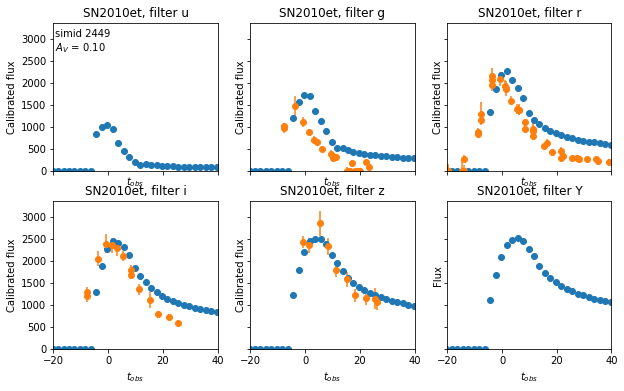

In [10]:
realdatacomp(X,y,realfile='SN2010et.snana.dat',idx=100)